# Improving on Cheby-Shev anomaly detection using robust estimators.

As discussed at the end of the notebook titled [*Using Chebyshev's inequality to detect accumulated precipitation data anomalies.*](https://github.com/mesowx/precip_anomaly_detection/blob/master/precip_anomaly_detection_chebyshev.ipynb) we are now going to look at the same process, but using robust estimators instead of the usual sample estimators. We will briefly summarize what these estimators are and how they are defined and then we will look at using them in our Cheby computation.

## Estimators
An estimator is loosely defined as a function of the data that estimates a statistic of the data. The easiest example is sample mean $\dfrac{1}{n}\sum^{n}_{i=1}X_{i}$ which estimates $\mu$ the mean based off the data $X_i$. A robust estimator resists the bias introduced by outliers. The median is an example of a robust mean. 

For our calculations we will use the median to estimate the expectation of our groups and to estimate the variance we will use the median absolute deviation and square it to estimate the variance. The median absolute deviation or MAD is defined as $\text{median}\left(|x_1 - \text{median}(X)|, |x_2 - \text{median}\left(X\right)|, \dots, |x_n - \text{median}(X)|\right)$.

## Using robust estimators
We will go through the same examples as before in [*Using Chebyshev's inequality to detect accumulated precipitation data anomalies.*](https://github.com/mesowx/precip_anomaly_detection/blob/master/precip_anomaly_detection_chebyshev.ipynb) Except that we will use our new robust estimators instead of the usual ones. I will run both computations side by side so that we can see the differences.


In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import numpy as np
import os.path
import requests
import json
import pandas as pd
from statsmodels import robust
from datetime import datetime
from pandas.io.json import json_normalize
%run ./functions.ipynb

In [2]:
def _plot_(x):
    plt.hist(x,bins=15)
    plt.xlabel('Precip')
    plt.ylabel('Count')
    plt.title('Precip frequency')
    plt.show()
    plt.plot(x, '-o', label='Precip')
    med = np.median(x)
    mad = robust.mad(x)
    mu = x.mean()
    std = x.std()
    plt.hlines(med, xmin=0, xmax=x.shape[0]-1, label='Median')
    plt.hlines([med+mad, med-mad], xmin=0, xmax=x.shape[0]-1, 
               linestyles='dashed', label='1 MAD')
    plt.hlines(mu, xmin=0, xmax=x.shape[0]-1, label='Mean', colors='y')
    plt.hlines([mu+std, mu-std], xmin=0, xmax=x.shape[0]-1, 
               linestyles='dashed', label='1 Std', colors='y')
    plt.xlabel('Index')
    plt.ylabel('Precip')
    plt.legend()
    plt.show()

#### Normal (5,2)
First we revisit the normal approach, then we will use the new estimators.

X:  [6.3315865  5.71527897 3.45459971 4.99161615 5.62133597 4.27991444
 5.26551159 5.10854853 5.00429143 4.82539979 5.43302619 6.20303737
 4.03493433 6.02827408 5.22863013] 

Alpha: 0.0, 
Mu: 5.1683990121842855  Mu*: 5.228630130124659, 
Var: 0.5960567787571353  Var*: 0.35740094530196986, 
Bound: 0.02231390407785536  Bound*: 0.013073138265475672

Alpha: 1.0, 
Mu: 5.1683990121842855  Mu*: 5.228630130124659, 
Var: 0.5960567787571353  Var*: 0.35740094530196986, 
Bound: 0.03430433958152741  Bound*: 0.019987399680952016

Alpha: 2.0, 
Mu: 5.1683990121842855  Mu*: 5.228630130124659, 
Var: 0.5960567787571353  Var*: 0.35740094530196986, 
Bound: 0.059375583829553207  Bound*: 0.034286180419179954

Alpha: 3.0, 
Mu: 5.1683990121842855  Mu*: 5.228630130124659, 
Var: 0.5960567787571353  Var*: 0.35740094530196986, 
Bound: 0.12676788070744696  Bound*: 0.07195810229539963

Alpha: 4.0, 
Mu: 5.1683990121842855  Mu*: 5.228630130124659, 
Var: 0.5960567787571353  Var*: 0.35740094530196986, 
Bound: 0.436621652

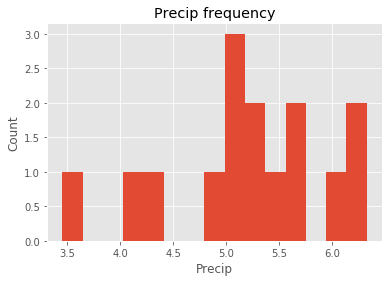

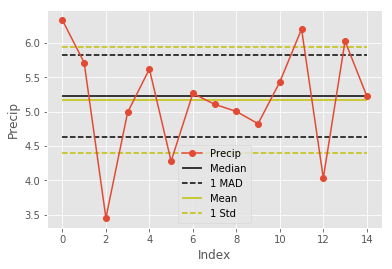

In [3]:
np.random.seed(10)
x = np.random.normal(5,1,15)
# sample mean and variance
print('X: ', x, '\n')
mu = x.mean()
var = x.var()
mu_star = np.median(x)
var_star = robust.mad(x)**2
for i in np.linspace(0,19,20):
    alpha = i
    epsilon = alpha-mu
    bound = var/(epsilon**2)
    epsilon_star = alpha-mu_star
    bound_star = var_star/(epsilon_star**2)

    print('Alpha: {}, \nMu: {}  Mu*: {}, \nVar: {}  Var*: {}, \nBound: {}  Bound*: {}\n'.format(
        alpha, mu, mu_star, var, var_star, bound, bound_star))
    
_plot_(x)

On a normal distribution we do not get a good representation of the effectiveness because we know mathematically that the sample mean/variance are the best estimators of a normal distribution. However it works very well for values on the tails of the distribution.
## Real World Datasets
First we'll look at the good dataset and the the dataset riddled with anomalies.

**Texas Dataset**

In [4]:
# A api call to a 'normal' set of precip data. not normal as in distribution, but in colloquial terms. 
normal_ex = "http://api.mesowest.net/v2/stations/precip?&radius=30,-97.8,15&token=demotoken&units=english&timeformat=%s&pmode=totals&start=201809150000&end=201810150000&network=1,2,213,234,106123,225,187"

In [5]:
# A api call to a 'normal' set of precip data. not normal as in distribution, but in colloquial terms. 
normal_ex = "http://api.mesowest.net/v2/stations/precip?&radius=30,-97.8,15&token=demotoken&units=english&timeformat=%s&pmode=totals&start=201809150000&end=201810150000&network=1,2,213,234,106123,225,187"

normal_ex_df = pd.DataFrame()

file_exist = os.path.isfile('./normal_ex.csv')

if file_exist:
    normal_ex_df = pd.read_csv('./normal_ex.csv')
else:
    print("File not found. Re-acquiring data from API. Results may vary.")
    normal_ex_df = make_dataframe(query_string=normal_ex)
    normal_ex_df.to_csv('./normal_ex.csv', index=False)
    
normal_ex_df

,DISTANCE,ELEVATION,ELEV_DEM,ID,LATITUDE,LONGITUDE,MNET_ID,NAME,RESTRICTED,STATE,STATUS,STID,TIMEZONE,ACCUM_30_DAYS,EPOCH_TIMEDELTA,COUNT
0,14.54,486,488.8,4329,30.183040,-97.679870,1,Austin-Bergstrom International Airport,False,TX,ACTIVE,KAUS,America/Chicago,3.04,2592000,977
1,8.31,597,587.3,4805,29.893610,-97.864720,1,"San Marcos, San Marcos Municipal Airport",False,TX,ACTIVE,KHYI,America/Chicago,2.93,2592000,1190
2,12.99,722,790.7,39734,30.176667,-97.874167,2,SOUTH AUSTIN RAWS,False,TX,ACTIVE,AURT2,America/Chicago,5.39,2592000,719
3,13.72,877,908.8,41685,30.083400,-98.008100,187,Driftwood 4 SSE,False,TX,ACTIVE,DRCT2,America/Chicago,5.80,2592000,2880
4,11.47,862,885.8,41686,30.141630,-97.900200,187,Manchaca 4 W,False,TX,ACTIVE,MTCT2,America/Chicago,5.01,2592000,2880
5,13.94,482,482.3,41687,30.177320,-97.688960,187,Onion Creek at Hwy 183 - Austin,False,TX,ACTIVE,ATIT2,America/Chicago,3.38,2592000,2879
6,13.13,526,541.3,41694,29.937330,-97.593000,187,Lockhart 6 NE,False,TX,ACTIVE,LRCT2,America/Chicago,2.12,2592000,2878
7,13.17,864,869.4,63148,29.939053,-98.008392,2,SAN MARCOS-WEST,False,TX,ACTIVE,SRWT2,America/Chicago,4.68,2595600,721
8,1.23,650,656.2,63149,29.998242,-97.820453,2,KYLE-EAST,False,TX,ACTIVE,KRET2,America/Chicago,3.84,2595600,721
9,13.98,588,597.1,63375,30.194930,-97.737390,225,Teri Road near Nuckols Crossing,False,TX,ACTIVE,TNCT2,America/Chicago,4.00,2592900,2877


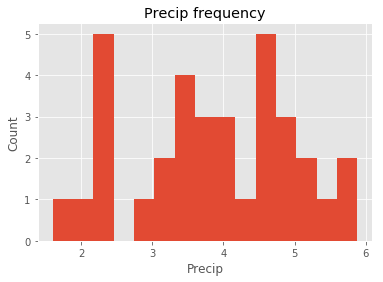

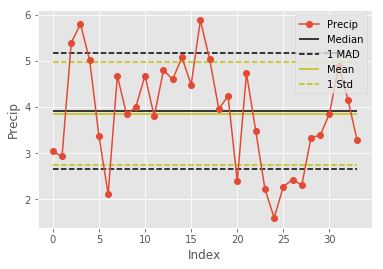

In [6]:
_plot_(normal_ex_df['ACCUM_30_DAYS'].values)

In [7]:
# compute chebyshev bound for all stations within 6 miles of the center of our radius
# distance filter 
# TODO remove the point of interest from the mean computation to eliminate bias
norm_dist_filter = normal_ex_df['DISTANCE'] <= 6 # miles
total_precip = np.array(normal_ex_df.filter(regex='ACCUM.*'))
mu = total_precip.mean()
var = total_precip.var()
mu_star = np.median(total_precip)
var_star = robust.mad(total_precip)**2
print('Mean: ', mu)
print('Median: ', mu_star)
print('Variance: ', var)
print('Variance*: ', var_star)
print('Std Dev: ', var**.5)
print('MAD: ', var_star**.5)

norm_ex_bound_col = np.full(normal_ex_df.shape[0], np.nan, dtype='float')
norm_ex_bound_col2 = np.full(normal_ex_df.shape[0], np.nan, dtype='float')

for i, row in  normal_ex_df[norm_dist_filter].iterrows():
    alpha = row.filter(regex='ACCUM.*').values
    
    epsilon = alpha-mu
    bound = var/(epsilon**2)
    
    epsilon_star = alpha-mu_star
    bound_star = var_star/(epsilon_star**2)
    
    norm_ex_bound_col[i] = bound
    norm_ex_bound_col2[i] = bound_star
    
# make new colum
normal_ex_df['CHEBY_BOUND'] = norm_ex_bound_col
normal_ex_df['ROBUST_BOUND'] = norm_ex_bound_col2

# filter out the ones we actually computed
normal_ex_df[~normal_ex_df['CHEBY_BOUND'].isna()]

Mean:  3.857058823529411
Median:  3.91
Variance:  1.242173702422145
Variance*:  [1.56950502]
Std Dev:  1.1145284664027855
MAD:  [1.25279887]


,DISTANCE,ELEVATION,ELEV_DEM,ID,LATITUDE,LONGITUDE,MNET_ID,NAME,RESTRICTED,STATE,STATUS,STID,TIMEZONE,ACCUM_30_DAYS,EPOCH_TIMEDELTA,COUNT,CHEBY_BOUND,ROBUST_BOUND
8,1.23,650,656.2,63149,29.998242,-97.820453,2,KYLE-EAST,False,TX,ACTIVE,KRET2,America/Chicago,3.84,2595600,721,4268.587396,320.307147
26,4.49,501,508.5,72087,29.974680,-97.730860,234,Rogers Ranch Rd,False,TX,ACTIVE,GBR09,America/Chicago,2.43,2347200,625,0.609956,0.716538
28,2.59,646,656.2,72109,29.992590,-97.842410,234,Bunton Lane,False,TX,ACTIVE,GBR14,America/Chicago,3.34,2346480,625,4.646248,4.830733
29,4.74,724,725.1,72110,30.029690,-97.728640,234,Engelke Rd,False,TX,ACTIVE,GBR15,America/Chicago,3.39,2346480,625,5.694285,5.804382
30,5.35,778,774.3,72111,30.049290,-97.868970,234,Hays Youth Complex,False,TX,ACTIVE,GBR16,America/Chicago,3.86,2349060,625,143595.280000,627.802008
32,5.75,840,853.0,72113,30.014870,-97.894530,234,Rocking M Rd,False,TX,ACTIVE,GBR18,America/Chicago,4.16,2346540,625,13.535232,25.112080
33,3.92,642,652.9,72114,29.943210,-97.799130,234,FM 21 off FM 2720,False,TX,ACTIVE,GBR19,America/Chicago,3.28,2346480,624,3.730286,3.954409


When we compare the two bound in the last 2 columns of the dataframe we can see that it behaves similarly to the sample estimators on a normal dataset with no outliers. In fact the robust estimators bump up the bound for the smallest precip value making it more likely to happen, and it did happen. These estimators look like they will keep us from miss classifying any observations. This is always good!

**Dugway Dataset**

In [8]:
# URLs
dugway_ex_dpg13 = "http://api.synopticlabs.org/v2/stations/precipitation?token=demotoken&radius=DPG13,15&timeformat=%s&pmode=totals&start=201803010000&end=201810140000&units=english"
dugway_ex_dpg04 = "http://api.synopticlabs.org/v2/stations/precipitation?token=demotoken&radius=DPG04,15&timeformat=%s&pmode=totals&start=201803010000&end=201810140000&units=english"

In [9]:
# Make initial dataframe
dugway_ex_dpg13_df = pd.DataFrame()
dugway_ex_dpg04_df = pd.DataFrame()

file_exist_dpg13 = os.path.isfile('./dugway_ex_dpg13.csv')
file_exist_dpg04 = os.path.isfile('./dugway_ex_dpg04.csv')

if file_exist_dpg13:
    dugway_ex_dpg13_df = pd.read_csv('./dugway_ex_dpg13.csv')
else:
    print("File not found. Re-acquiring data from API. Results may vary.")
    dugway_ex_dpg13_df = make_dataframe(query_string=dugway_ex_dpg13)
    dugway_ex_dpg13_df.to_csv('./dugway_ex_dpg13.csv', index=False)
    
if file_exist_dpg04:
    dugway_ex_dpg04_df = pd.read_csv('./dugway_ex_dpg04.csv')
else:
    print("File not found. Re-acquiring data from API. Results may vary.")
    dugway_ex_dpg04_df = make_dataframe(query_string=dugway_ex_dpg04)
    dugway_ex_dpg04_df.to_csv('./dugway_ex_dpg04.csv', index=False)

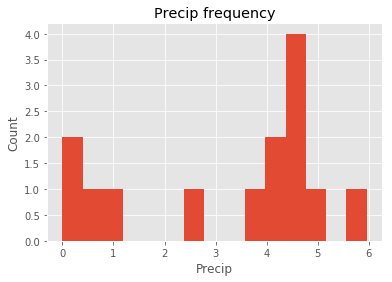

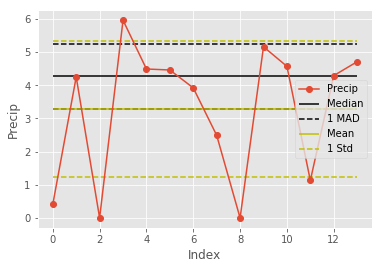

In [10]:
_plot_(dugway_ex_dpg13_df['ACCUM_226_DAYS'])

**Note:** We can already see the impact the robust estimators are having just by looking at a plot of the data points. It is very clear when you look at the black horizontal lines that the bottom values are outliers.

In [11]:
# compute chebyshev bound for dpg04
# stid filter 
dpg04_filter = dugway_ex_dpg04_df['STID'] == 'DPG04'
total_precip = np.array(dugway_ex_dpg04_df.filter(regex='ACCUM.*')[~dpg04_filter])
mu = total_precip.mean()
var = total_precip.var()
mu_star = np.median(total_precip)
var_star = robust.mad(total_precip)**2
print('Mean: ', mu)
print('Median: ', mu_star)
print('Variance: ', var)
print('Variance*: ', var_star)
print('Std Dev: ', var**.5)
print('MAD: ', var_star**.5)

dugway_dpg04_bound_col = np.full(dugway_ex_dpg04_df.shape[0], np.nan, dtype='float')
dugway_dpg04_bound_col2 = np.full(dugway_ex_dpg04_df.shape[0], np.nan, dtype='float')

for i, row in dugway_ex_dpg04_df[dpg04_filter].iterrows():
    alpha = row.filter(regex='ACCUM.*').values
    
    epsilon = alpha-mu
    bound = var/(epsilon**2)
    
    epsilon_star = alpha-mu_star
    bound_star = var_star/(epsilon_star**2)
    
    dugway_dpg04_bound_col[i] = bound
    dugway_dpg04_bound_col2[i] = bound_star
    
# make new colum
dugway_ex_dpg04_df['CHEBY_BOUND'] = dugway_dpg04_bound_col
dugway_ex_dpg04_df['ROBUST_BOUND'] = dugway_dpg04_bound_col2

# filter out the ones we actually computed
dugway_ex_dpg04_df[~dugway_ex_dpg04_df['CHEBY_BOUND'].isna()]

Mean:  4.618333333333333
Median:  4.27
Variance:  13.091547222222223
Variance*:  [0.34296001]
Std Dev:  3.618224318947379
MAD:  [0.58562788]


,DISTANCE,ELEVATION,ELEV_DEM,ID,LATITUDE,LONGITUDE,MNET_ID,NAME,RESTRICTED,STATE,STATUS,STID,TIMEZONE,ACCUM_226_DAYS,EPOCH_TIMEDELTA,COUNT,CHEBY_BOUND,ROBUST_BOUND
3,0.0,4349,4370.1,451,40.04602,-113.0455,3,TARGET S,False,UT,ACTIVE,DPG04,America/Denver,0.0,19613100,59879,0.613791,0.01881


Notice the significant increase in performance. We went from 60% to 1%. Remember we want this bound to be small if the datapoint is an outlier. That means that the probability of observing this data is less than or equal to our bound. Choosing a 5% threshold would be more strict on the classifying the outliers and choosing 1% would be more conservative.
## Moving Forward
Now that we have explored one way to narrow down on the outliers we can scale this up to any dataset. We will also explore an algorithm to go along side this that uses similar techniques, but it isn't a probability bound, it is a probability approximation.